In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
from graphviz import Digraph
import torch
import random 


### Class representation

In [32]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data = {self.data})"

  def __add__(self, other):
    # a + 1 will become a + Value(1)
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    #addition backpropagation 
    def _backward():
      # += is for variables that are repeating into different nodes e.g c = b*a and d = a + b
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    #other * self (reverse multiplication for cases like 2 * a)
    return (self * other)
  
  def __pow__(self, other):
    #supporting only int/float powers
    assert isinstance(other, (int,float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad = other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * (other**-1)
    
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    #the local derivative of tanh * grad
    def _backward():
        self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
        self.grad += out.data * out.grad

    out._backward = _backward

    return out
  
  def backward(self):
    """Builds a topological graph of the nodes (implementation of back propagration"""
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


### Visualization function


In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    #assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

## Manual backpropagation

recursive application of chain rule

In [ ]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e + c; d.label="d"
f = Value(-2.0); f.label="f"
L = d * f; L.label="L"
L

In [ ]:
#prints out the value of a*b and c
d._prev

{value(data = -6.0), value(data = 10.0)}

In [ ]:
#what produced d 
d._op

'+'

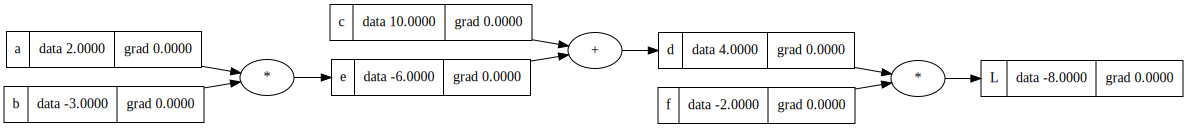

In [ ]:
draw_dot(L)

GRADIENT CHECK: deriving the backpropagetion and getting the derivative 
NUUMERICAL GRADIENT estimating the derivative using small step size

for backward,
we calculate the derivative of each node with respect to L

In Neural nets, the derivative of the weights of a neural net wrt the loss function i.e to fnd how the weights are impacting the loss function

In [ ]:
L.grad = 1.0
# dL/df = d
f.grad = 4.0
# dL/dd = f
d.grad = -2.0

In [ ]:
"""dd/dc  d = c + e = e = 1.0
dl/dc using chain rule dd/dc * dl*dd
1.0 * -2.0 = -2.0
"""
c.grad = -2.0
"""
dd/de  d = c + e = c = 1.0
dl/de using chain rule  dd/de * dl*dd
1.0 * -2.0 = -2.0
"""
e.grad = -2.0

In [ ]:
"""de/da  (e = a + b) = b = -3.0
dl/da using chain rule de/da * dl*de
-3.0 * -2.0 = 6.0
"""
a.grad = 6.0
"""
de/db  (e = a + b) = a = 2.0
dl/de using chain rule  de/db * dl*de
2.0 * -2.0 = -4.0
"""
b.grad = -4.0

In [ ]:
def test_fnc():
  h = 0.001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label="e"
  d = e + c; d.label="d"
  f = Value(-2.0); f.label="f"
  L = d * f; L.label="L"
  L1 = L.data


  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label="e"
  d = e + c; d.label="d"
  d.data += h
  f = Value(-2.0); f.label="f"
  L = d * f; L.label="L"
  L2 = L.data

  print((L2 - L1)/h) #prints the derivate of l wrt a

test_fnc()

-2.000000000000668


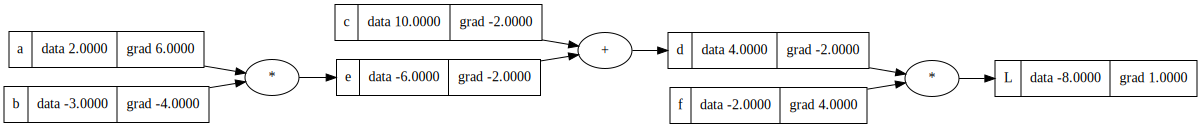

In [ ]:
draw_dot(L)

In [ ]:
#each input node should incrrease in the direction of gradient 
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad
f.data += 0.001 * f.grad
c.data += 0.001 * c.grad

e = a*b; 
d = e + c;

L = d * f
print(L.data)

-7.928064095999999


## Manual Backprop with weights

In [4]:
x1 = Value(2.0, label='x1')
x2 = Value (0.0,label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function 
o = n.tanh(); o.label = 'o/p'



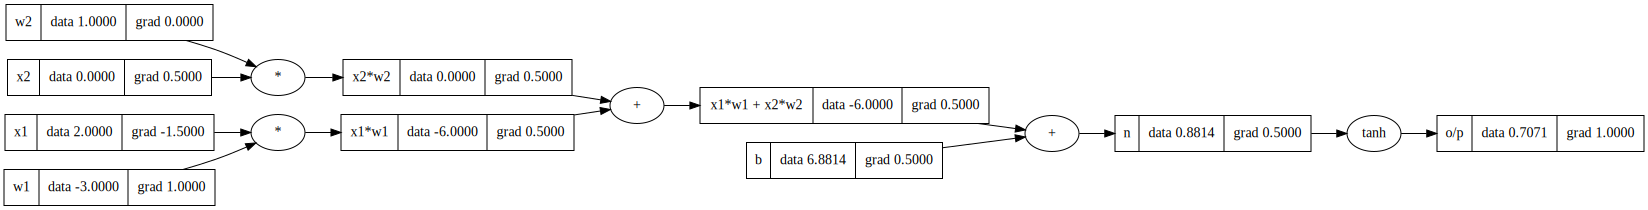

In [14]:
draw_dot(o)

In [6]:
o.grad = 1.0

In [8]:
"""local derivate of tan(h) 
do/dn = 1 - tanh(x)**2 1 - o**2
"""
n.grad = round((1 - o.data**2), 1)

In [10]:
# since for +, the grad flows to the nodes that are being added 
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [11]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [12]:
"""
do/dx2 = do/dx2w2 * dx2w2/dx2
dx2w2/dx2 = x2 * w2 = w2
"""
x2.grad = x2w2.grad * w2.data
"""
since the gradient of w2.is 0 and 
the gradient tells us the effect on the final output
therefore changing w2 has no effect 
"""
w2.grad = x2w2.grad * x2.data

In [13]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

## Automated Backpropagation


In [21]:
x1 = Value(2.0, label='x1')
x2 = Value (0.0,label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function 
o = n.tanh(); o.label = 'o/p'

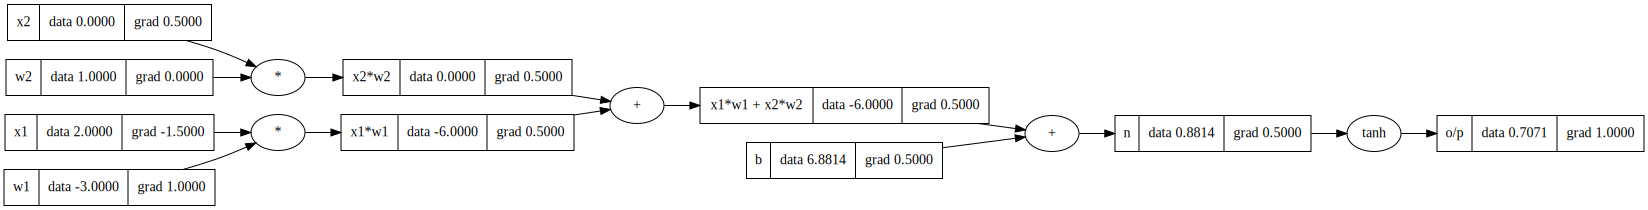

In [29]:
draw_dot(o)

In [23]:
#set to 1.0 as a base case
o.grad = 1.0
o._backward()

In [25]:
n._backward()

In [26]:
x1w1x2w2._backward()

In [27]:
x2w2._backward()

In [28]:
x1w1._backward()

In [ ]:
#witht the backward function, we can call the function without the underscore
o.backward()

#### Topological sort




*   All the edges go left to right
*   O only adds itself to the list after all the child nodes have been added


In [30]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

In [31]:
build_topo(o)
topo

[value(data = 6.881373587019543),
 value(data = -3.0),
 value(data = 2.0),
 value(data = -6.0),
 value(data = 1.0),
 value(data = 0.0),
 value(data = 0.0),
 value(data = -6.0),
 value(data = 0.8813735870195432),
 value(data = 0.7071067811865476)]

## Breaking tanh into a function of x

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value (0.0,label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function o = n.tanh()
e = (2*n).exp()
o = (e - 1) / ( e + 1)
# ------
o.label = 'o/p'
o.backward()

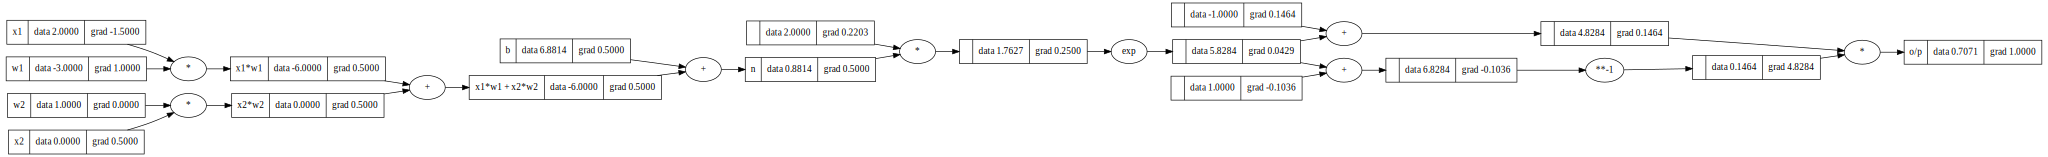

In [ ]:
draw_dot(o)